In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms

In [3]:
batch_size = 4096

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
dataset = datasets.MNIST(root="data/", download=True, transform=transform)
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=True,
)

test_dataset = datasets.MNIST(root="data/", train=False, transform=transform)
test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, num_workers=4, pin_memory=True
)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 491kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.8MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [27]:

class SimpleVgg(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleVgg, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 3 * 3, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [3]:
class FlatModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        return x

In [4]:
class DenseModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.stack(x)
        return x

In [5]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Linear(1024, 10),
        )

    def forward(self, xb):
        out = self.stack(xb)
        return out

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")
model = SimpleVgg().to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
crit = nn.CrossEntropyLoss()

test_losses = []
losses = []


def test():
    with torch.no_grad():
        test_loss = 0
        for i, (images, labels) in enumerate(test_dataloader):
            out = model(images.to(device))
            test_loss += F.cross_entropy(out, labels.to(device), reduction="sum").item()
        test_loss /= len(test_dataset)

    return test_loss


epochs = 30

logging_interval = 10
def train(epochs):
    for epoch in range(epochs):
        for i, (images, labels) in enumerate(dataloader):
            out = model(images.to(device))
            loss = crit(out, labels.to(device))
            loss.backward()
            optim.step()
            optim.zero_grad()

            if i % logging_interval == 0:
                losses.append(loss.item())
                test_losses.append(test())

        print(f"Epoch: {epoch}, Loss: {loss.item()}")


train(epochs)

Running on cuda


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch: 0, Loss: 0.9258940815925598
Epoch: 1, Loss: 0.3888757526874542
Epoch: 2, Loss: 0.22246593236923218
Epoch: 3, Loss: 0.17179368436336517
Epoch: 4, Loss: 0.1433241367340088
Epoch: 5, Loss: 0.10893544554710388
Epoch: 6, Loss: 0.10594452172517776
Epoch: 7, Loss: 0.10308198630809784
Epoch: 8, Loss: 0.08503291755914688
Epoch: 9, Loss: 0.0682559460401535
Epoch: 10, Loss: 0.07860766351222992
Epoch: 11, Loss: 0.06254665553569794
Epoch: 12, Loss: 0.06606069952249527
Epoch: 13, Loss: 0.05905253440141678
Epoch: 14, Loss: 0.04565565288066864
Epoch: 15, Loss: 0.04923313856124878
Epoch: 16, Loss: 0.04871351271867752
Epoch: 17, Loss: 0.04058869183063507
Epoch: 18, Loss: 0.04669562727212906
Epoch: 19, Loss: 0.03989056497812271
Epoch: 20, Loss: 0.04846763610839844
Epoch: 21, Loss: 0.04034842923283577
Epoch: 22, Loss: 0.03254873305559158
Epoch: 23, Loss: 0.033254507929086685
Epoch: 24, Loss: 0.030654702335596085
Epoch: 25, Loss: 0.028472505509853363
Epoch: 26, Loss: 0.026239801198244095
Epoch: 27, 

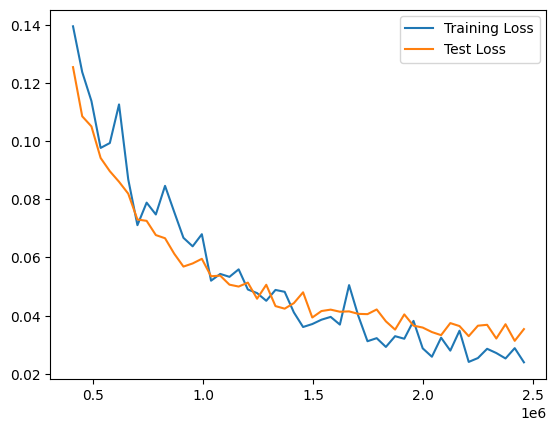

In [29]:
import matplotlib.pyplot as plt
import numpy as np

o = 10
d = len(losses)

plt.plot(np.linspace(o * logging_interval * batch_size, d * logging_interval * batch_size, d - o), losses[o:d])
plt.plot(np.linspace(o * logging_interval * batch_size, d * logging_interval * batch_size, d - o), test_losses[o:d])
plt.legend(['Training Loss', 'Test Loss'])
# plt.plot(list(map(lambda x: np.log(x), losses)), color='#9fbd59')

In [30]:
train(10)

Epoch: 0, Loss: 0.023123648017644882
Epoch: 1, Loss: 0.02170969359576702
Epoch: 2, Loss: 0.02688528597354889
Epoch: 3, Loss: 0.031170407310128212
Epoch: 4, Loss: 0.019099680706858635
Epoch: 5, Loss: 0.02466784417629242
Epoch: 6, Loss: 0.022523662075400352
Epoch: 7, Loss: 0.01656532846391201
Epoch: 8, Loss: 0.020676635205745697
Epoch: 9, Loss: 0.017541203647851944


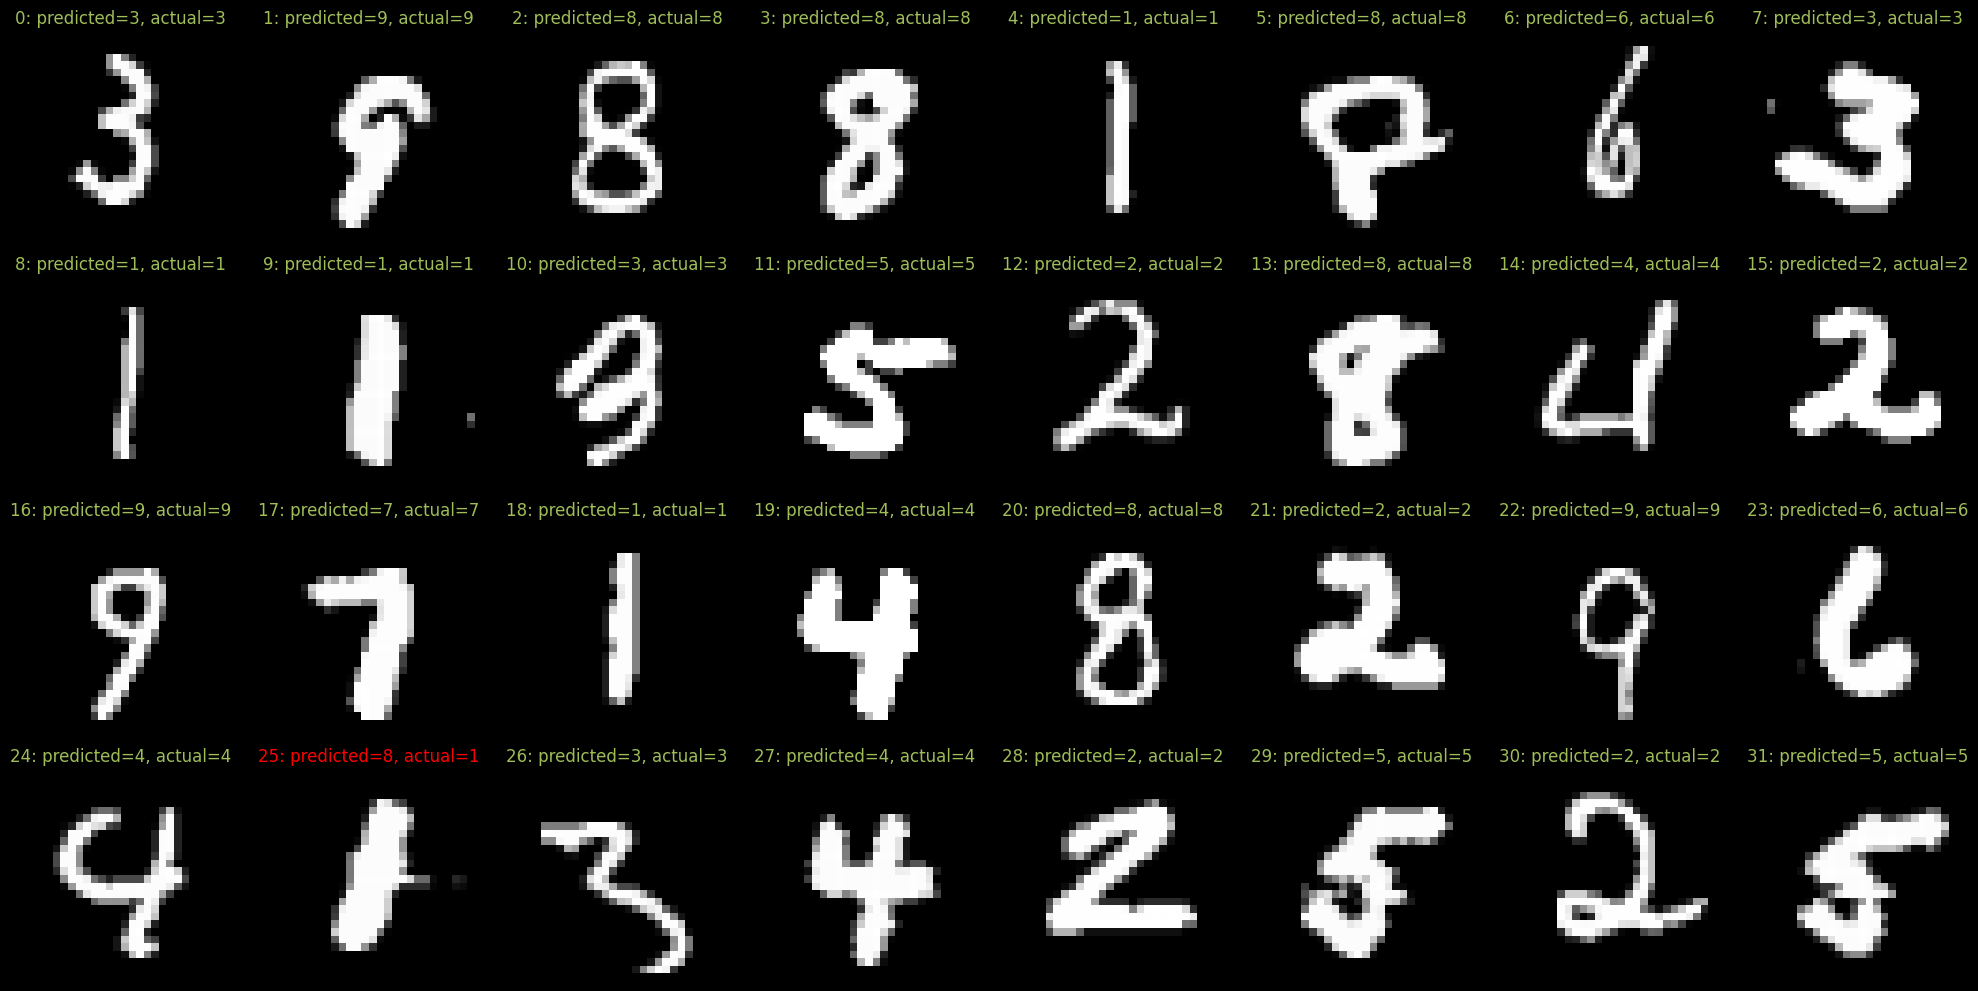

In [31]:
fig, axs = plt.subplots(4, 8, figsize=(20, 10))
axs = axs.flatten()

offset = 1234

images = dataset.data[offset : 32 + offset].float().unsqueeze(1)
labels = dataset.targets[offset : 32 + offset]

with torch.no_grad():
    out = model(images.to(device))

for i in range(32):
    predicted = out[i].argmax().item()
    actual = labels[i].item()
    axs[i].imshow(images[i].reshape(28, 28), cmap="gray")
    if predicted != actual:
        axs[i].set_title(f"{i}: {predicted=}, {actual=}", color="red")
    else:
        axs[i].set_title(f"{i}: {predicted=}, {actual=}", color="#9fbd59")
    axs[i].axis("off")

plt.gcf().patch.set_facecolor('black')
plt.tight_layout()
plt.show()

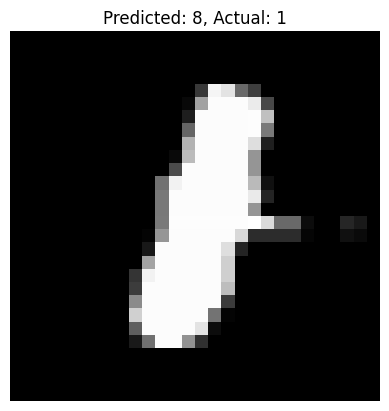

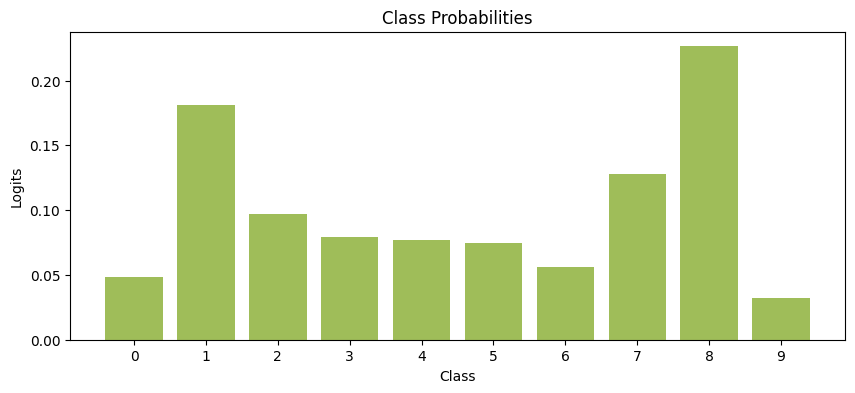

In [33]:
i = 25
with torch.no_grad():
    logits = model(images[i].unsqueeze(0).to(device))
plt.imshow(images[i].reshape(28, 28), cmap="gray")
plt.title(f"Predicted: {logits.argmax().item()}, Actual: {labels[i]}")
plt.axis("off")

heat = True

c = abs(1 / logits.sum()) if heat else 1
probabilities = ((logits - logits.max()) * c).softmax(dim=1)[0]
plt.figure(figsize=(10, 4))
plt.bar(range(10), probabilities.cpu().numpy(), color="#9fbd59")
plt.xticks(range(10))
plt.xlabel("Class")
plt.ylabel("Logits")
plt.title("Class Probabilities")
plt.show()

In [34]:
torch.save(model.state_dict(), "vgg_model.pth")

In [35]:
model.load_state_dict(torch.load("vgg_model.pth", weights_only=True))

<All keys matched successfully>

In [36]:
sum(torch.numel(p) for p in nn.Conv2d(32, 32, 2, 3).parameters())

4128